### 1.

###  Loading csv Daily Analysis file

In [1]:
#################################################################
###### Load The Daily JohnHopkins + 1Day Notebook Analysis ######
#################################################################
###
### Input delta in folder :  /data
configs = {"analytics_date":"2020-10-31"}
anltdate="2020-10-31"
my_input_csv_table="World_v2--Confirmed-1Day_Forecast_--_train_"+anltdate+"-copy1.csv"
delta_location_covid19="file:///home/notebookuser/notebooks/data/delta_daily-covid19-global-analysis/dt="+anltdate
###
######
##############################Execution##########################
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
import subprocess
#
sc = pyspark.SparkContext(appName="Daily-Covid19-Global-Analysis")
sqlContext = SQLContext(sc)
#
#
internal_csv_files="file:///home/notebookuser/notebooks/covid19/data/"+my_input_csv_table
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
### Scructure
from pyspark.sql.types import StructField,IntegerType,StructType,StringType,FloatType,DoubleType
newDF=[StructField('date',StringType(),True),
       StructField('region',StringType(),True),
       StructField('confirmed',StringType(),True),
       StructField('1_day_change',FloatType(),True),
       StructField('3_day_change',FloatType(),True),
       StructField('7_day_change',FloatType(),True),
       StructField('1_day_change_rate',DoubleType(),True),
       StructField('3_day_change_rate',DoubleType(),True),
       StructField('7_day_change_rate',DoubleType(),True),
       StructField('confirmed_yesterday',FloatType(),True),
       StructField('confirmed_prediction',FloatType(),True),
       StructField('population',FloatType(),True),
       StructField('infected_rate',DoubleType(),True),
       StructField('min',FloatType(),True),
       StructField('max',FloatType(),True),
       StructField('population_percentage_infected_rate_confirmed',DoubleType(),True),
       StructField('population_percentage_factor_9a10_infected_rate_confirmed',DoubleType(),True),
       StructField('delta_new_cases',FloatType(),True),
       StructField('delta_new_cases_per_1M_hab',FloatType(),True),
       StructField('delta_roling_7day_AVG',FloatType(),True),
       StructField('delta_aprox_14day_case_notification_rate_per_100k_hab',FloatType(),True)
       ]
finalStruct=StructType(fields=newDF)
#
dataframe_df1=sqlContext.read.csv(internal_csv_files,header="true",schema=finalStruct)\
.fillna("",subset=['date', 'region'])\
.fillna(0, subset=['1_day_change', '3_day_change', '7_day_change', 'confirmed_yesterday', 'confirmed_prediction', 'population', 'infected_rate', 'min', 'max', 'population_percentage_infected_rate_confirmed', 'population_percentage_factor_9a10_infected_rate_confirmed', 'population_percentage_factor_9a10_infected_rate_confirmed', 'delta_new_cases', 'delta_new_cases_per_1M_hab', 'delta_roling_7day_AVG', 'delta_aprox_14day_case_notification_rate_per_100k_hab'])\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
## as confirmed is null in "today's date" it created a conflict wirh spark hashing
###
##Py4JJavaError: An error occurred while calling o69.collectToPython.
##: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 14.0 failed 1 times, most recent failure: Lost task 0.0 in stage 14.0 (TID 258, localhost, executor driver): org.apache.hadoop.fs.ChecksumException: Checksum error: file:/home/notebookuser/notebooks/data/delta_daily-covid19-global-analysis/part-00002-eb251372-48d4-46e2-a41c-36ec8e3284e0-c000.snappy.parquet at 0 exp: 4760148 got: -1297451656
##	at org.apache.hadoop.fs.FSInputChecker.verifySums(FSInputChecker.java:323)
##	at org.apache.hadoop.fs.FSInputChecker.readChecksumChunk(FSInputChecker.java:279)
##	at org.apache.hadoop.fs.FSInputChecker.fill(FSInputChecker.java:214)
##	at org.apache.hadoop.fs.FSInputChecker.read1(FSInputChecker.java:232)
###    
columns_to_drop = ['1_day_change_rate', '3_day_change_rate', '7_day_change_rate', 'infected_rate', 'min', 'max']
#
dataframe_df1.printSchema()
dataframe_df1.drop(*columns_to_drop).show(5)
df2=dataframe_df1.drop(*columns_to_drop)
df2.write.mode('overwrite').format("delta").save(delta_location_covid19)
###
####
## sc.stop()
#
print("Data Load Done!")
#

root
 |-- date: string (nullable = false)
 |-- region: string (nullable = false)
 |-- confirmed: string (nullable = true)
 |-- 1_day_change: float (nullable = false)
 |-- 3_day_change: float (nullable = false)
 |-- 7_day_change: float (nullable = false)
 |-- 1_day_change_rate: double (nullable = true)
 |-- 3_day_change_rate: double (nullable = true)
 |-- 7_day_change_rate: double (nullable = true)
 |-- confirmed_yesterday: float (nullable = false)
 |-- confirmed_prediction: float (nullable = false)
 |-- population: float (nullable = false)
 |-- infected_rate: double (nullable = false)
 |-- min: float (nullable = false)
 |-- max: float (nullable = false)
 |-- population_percentage_infected_rate_confirmed: double (nullable = false)
 |-- population_percentage_factor_9a10_infected_rate_confirmed: double (nullable = false)
 |-- delta_new_cases: float (nullable = false)
 |-- delta_new_cases_per_1M_hab: float (nullable = false)
 |-- delta_roling_7day_AVG: float (nullable = false)
 |-- delta_a

### 2.


### Loading Data to Delta Lake for SparkSQL interrogations

In [3]:
##############################
###### Load The Delta   ######
##############################
###
### Input delta in folder :  /data 
my_input_delta_table="delta_daily-covid19-global-analysis"
anltdate="2020-10-31"
#
delta_table_name="covid19_jh_analysis"
###
######
##############################Execution##########################
import findspark
findspark.init()
#
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
import subprocess
3#
### CONTEXT required for 2nd,3rd,4th,5th runs
##
#sc = pyspark.SparkContext(appName="Daily-Covid19-Analysis-Delta")
#sqlContext = SQLContext(sc)
#
#
internal_delta_files="file:///home/notebookuser/notebooks/data/"+my_input_delta_table+"/dt="+anltdate
#
# Join with Internal Curation Data in urltopredict staged folder
from pyspark.sql import functions as F
delta_dataframe_df1=sqlContext.read.format("delta").load(internal_delta_files)\
.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
## ,schema=finalStruct)\
## Py4JJavaError: An error occurred while calling o48.load.
## : org.apache.spark.sql.AnalysisException: delta does not allow user-specified schemas.;
##      	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:325)
#
delta_dataframe_df1.printSchema()
delta_dataframe_df1.registerTempTable(delta_table_name)
#
#
print("Delta table "+delta_table_name+" : registration Done!")
#

root
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- 1_day_change: float (nullable = true)
 |-- 3_day_change: float (nullable = true)
 |-- 7_day_change: float (nullable = true)
 |-- confirmed_yesterday: float (nullable = true)
 |-- confirmed_prediction: float (nullable = true)
 |-- population: float (nullable = true)
 |-- population_percentage_infected_rate_confirmed: double (nullable = true)
 |-- population_percentage_factor_9a10_infected_rate_confirmed: double (nullable = true)
 |-- delta_new_cases: float (nullable = true)
 |-- delta_new_cases_per_1M_hab: float (nullable = true)
 |-- delta_roling_7day_AVG: float (nullable = true)
 |-- delta_aprox_14day_case_notification_rate_per_100k_hab: float (nullable = true)

Delta table covid19_jh_analysis : registration Done!


In [10]:
#sc.stop()

### 3.

### Registering SQL functions as jupyter line_cell_magic

In [4]:
#
###### https://github.com/LucaCanali/Miscellaneous/blob/master/Pyspark_SQL_Magic_Jupyter/IPython_Pyspark_SQL_Magic.py
#
#
# IPython magic functions to use with Pyspark and Spark SQL
# The following code is intended as examples of shorcuts to simplify the use of SQL in pyspark
# The defined functions are:
#
# %sql <statement>          - return a Spark DataFrame for lazy evaluation of the SQL
# %sql_show <statement>     - run the SQL statement and show max_show_lines (50) lines
# %sql_display <statement>  - run the SQL statement and display the results using a HTML table 
#                           - this is implemented passing via Pandas and displays up to max_show_lines (50)
# %sql_explain <statement>  - display the execution plan of the SQL statement
#
# Use: %<magic> for line magic or %%<magic> for cell magic.
#
# Author: Luca.Canali@cern.ch
# September 2016
#

from IPython.core.magic import register_line_cell_magic

# Configuration parameters
max_show_lines = 80         # Limit on the number of lines to show with %sql_show and %sql_display
detailed_explain = True     # Set to False if you want to see only the physical plan when running explain

#### Joao - Fix - inject - AnalyticsData
##configs = {'analytics_date': << THE_DATE >> } #,"TABLE_NAME":"my_table","SCHEMA":"my_schema"}
### 

@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs))

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).show(max_show_lines) 

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).limit(max_show_lines).toPandas() 

@register_line_cell_magic
def sql_explain(line, cell=None):
    "Display the execution plan of the sql. Use: %sql_explain or %%sql_explain"
    val = cell if cell is not None else line 
    return sqlContext.sql(val.format(**configs)).explain(detailed_explain)
#

### 4.


### Validate SPARK-SQL instructions  %%sql_display  %%sql_explain %%sql_show

In [5]:
%%sql_display
select * from covid19_jh_analysis  order by date desc limit 5

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab
0,2020-10-31,Romania_nan,0,6546.0,18370.0,34554.0,235586.0,239104.0,19530000.0,0.012063,0.120628,3518.0,180.133133,4936.285645,353.855621
1,2020-10-31,Saint Lucia_nan,0,2.0,13.0,30.0,78.0,83.0,10000000.0,0.000008,0.000079,5.0,0.500000,4.285714,0.600000
2,2020-10-31,Russia_nan,0,17987.0,51291.0,117433.0,1588433.0,1604396.0,144500000.0,0.010993,0.109926,15963.0,110.470589,16776.142578,162.537018
3,2020-10-31,Poland_nan,0,21629.0,60605.0,112516.0,340834.0,351854.0,37980000.0,0.008974,0.089741,11020.0,290.152710,16073.713867,592.501343
4,2020-10-31,Rwanda_nan,0,3.0,50.0,82.0,5134.0,5155.0,10000000.0,0.000513,0.005135,21.0,2.100000,11.714286,1.640000


### 5.


### The Regions in the World with +80 'notifications per 100k hab. in last 14days' and +300 cases yesterday

In [8]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= {analytics_date} and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 120
order by region asc
limit 50

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


In [9]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-10-31' and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 120
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab
0,2020-10-31,Argentina_nan,0,13379.0,40570.0,87811.0,1157179.0,1169919.0,45106700.0,0.025654,0.256543,12740.0,282.441406,12544.428711,389.347900
1,2020-10-31,Armenia_nan,0,2398.0,7022.0,14122.0,87432.0,89148.0,2962061.0,0.029518,0.295176,1716.0,579.326355,2017.428589,953.525269
2,2020-10-31,Austria_nan,0,5627.0,13474.0,25161.0,99576.0,101452.0,8822000.0,0.011287,0.112873,1876.0,212.650192,3594.428467,570.414856
3,2020-10-31,Belarus_nan,0,970.0,2890.0,6332.0,97499.0,98326.0,9449974.0,0.010317,0.103175,827.0,87.513466,904.571411,134.010956
4,2020-10-31,Belgium_nan,0,20056.0,65025.0,124614.0,412314.0,426862.0,11400000.0,0.036168,0.361680,14548.0,1276.140381,17802.000000,2186.210449
5,2020-10-31,Bosnia and Herzegovina_nan,0,1498.0,4986.0,9644.0,48137.0,49263.0,3285028.0,0.014654,0.146538,1126.0,342.767242,1377.714233,587.148743
6,2020-10-31,Brazil_nan,0,22282.0,77017.0,163002.0,5516658.0,5540649.0,212559008.0,0.025954,0.259535,23991.0,112.867485,23286.000000,153.371063
7,2020-10-31,Bulgaria_nan,0,2891.0,8340.0,14522.0,51041.0,52474.0,6959195.0,0.007334,0.073345,1433.0,205.914627,2074.571533,417.347107
8,2020-10-31,Canada_Alberta,0,622.0,1509.0,3403.0,27664.0,28136.0,4067175.0,0.006802,0.068020,472.0,116.051071,486.142853,167.339737
9,2020-10-31,Canada_Quebec,0,1108.0,3067.0,6726.0,104952.0,105794.0,8485000.0,0.012369,0.123692,842.0,99.233940,960.857117,158.538605


### 6.




### Regions of Risk where population.csv has not been fullfiled and may compromise ratios

In [10]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-10-31' and
    delta_roling_7day_AVG >= 300 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 80 and
    population >= 10000000 and population <= 10000000
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


In [11]:
%%sql_display
select * from covid19_jh_analysis where region is not null and
    date >= '2020-10-31' and
    delta_roling_7day_AVG >= 150 and
    delta_aprox_14day_case_notification_rate_per_100k_hab >= 50 and
    population >= 10000000 and population <= 10000000
order by region asc
limit 80

,date,region,confirmed,1_day_change,3_day_change,7_day_change,confirmed_yesterday,confirmed_prediction,population,population_percentage_infected_rate_confirmed,population_percentage_factor_9a10_infected_rate_confirmed,delta_new_cases,delta_new_cases_per_1M_hab,delta_roling_7day_AVG,delta_aprox_14day_case_notification_rate_per_100k_hab


### 7.


### Regions where population.csv has not been fulfilled and model has default 10,000,000 hab.

In [12]:
%%sql_display
select distinct(region) from covid19_jh_analysis 
where where region is not null and
    date >= '2020-10-31' and population >= 10000000 and population <= 10000000 order by region asc

,region
0,Antigua and Barbuda_nan
1,Australia_Australian Capital Territory
2,Australia_Northern Territory
3,Australia_Tasmania
4,Australia_Western Australia
5,Bahamas_nan
6,Barbados_nan
7,Belize_nan
8,Benin_nan
9,Bhutan_nan


In [13]:
%%sql_display
select distinct(region) from covid19_jh_analysis 
where where date >= '2020-10-31' and region > 'Saint Kitts and Nevis_nan' and
     population >= 10000000 and population <= 10000000 order by region asc

,region
0,Saint Lucia_nan
1,Saint Vincent and the Grenadines_nan
2,Sao Tome and Principe_nan
3,Senegal_nan
4,Seychelles_nan
5,Sierra Leone_nan
6,Solomon Islands_nan
7,Somalia_nan
8,South Sudan_nan
9,Sudan_nan


In [14]:
#
print("Analysis Done!")
#

Analysis Done!


### 8.


### Plot Today's analysis (TBA)

In [15]:
delta_display=sqlContext.sql("select region,date, confirmed_yesterday, \
 delta_aprox_14day_case_notification_rate_per_100k_hab, delta_roling_7day_AVG  \
 from covid19_jh_analysis where region is not null \
 and date >= '2020-10-11' and  date <= '2020-11-01' and delta_roling_7day_AVG >= 300 and \
 delta_aprox_14day_case_notification_rate_per_100k_hab >= 120 order by region asc")
#
delta_display.printSchema()
#
pdt=delta_display.toPandas()
t=pdt
#
print(t)

root
 |-- region: string (nullable = true)
 |-- date: string (nullable = true)
 |-- confirmed_yesterday: float (nullable = true)
 |-- delta_aprox_14day_case_notification_rate_per_100k_hab: float (nullable = true)
 |-- delta_roling_7day_AVG: float (nullable = true)

                     region        date  confirmed_yesterday  \
0               Albania_nan  2020-10-26              19157.0   
1             Argentina_nan  2020-10-11             883882.0   
2             Argentina_nan  2020-10-12             894206.0   
3             Argentina_nan  2020-10-13             903730.0   
4             Argentina_nan  2020-10-14             917035.0   
5             Argentina_nan  2020-10-15             931967.0   
6             Argentina_nan  2020-10-16             949063.0   
7             Argentina_nan  2020-10-17             965609.0   
8             Argentina_nan  2020-10-18             979119.0   
9             Argentina_nan  2020-10-19             989680.0   
10            Argentina_nan  2

In [16]:
sc.stop()

In [17]:
%matplotlib inline
##%matplotlib notebook

No handles with labels found to put in legend.


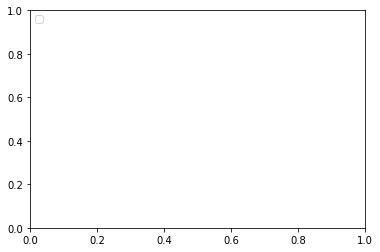

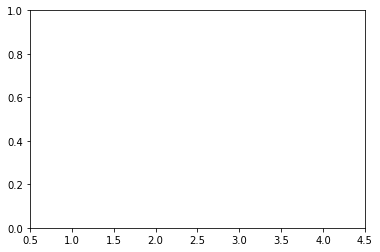

In [18]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
fig= plt.figure()
ax= fig.add_subplot(111)
ax.set_xlim(0.5, 4.5)
plt.show()

In [19]:
region=t['region']
print(region)

0                 Albania_nan
1               Argentina_nan
2               Argentina_nan
3               Argentina_nan
4               Argentina_nan
5               Argentina_nan
6               Argentina_nan
7               Argentina_nan
8               Argentina_nan
9               Argentina_nan
10              Argentina_nan
11              Argentina_nan
12              Argentina_nan
13              Argentina_nan
14              Argentina_nan
15              Argentina_nan
16              Argentina_nan
17              Argentina_nan
18              Argentina_nan
19              Argentina_nan
20              Argentina_nan
21              Argentina_nan
22                Armenia_nan
23                Armenia_nan
24                Armenia_nan
25                Armenia_nan
26                Armenia_nan
27                Armenia_nan
28                Armenia_nan
29                Armenia_nan
                ...          
968         United States_nan
969         United States_nan
970       

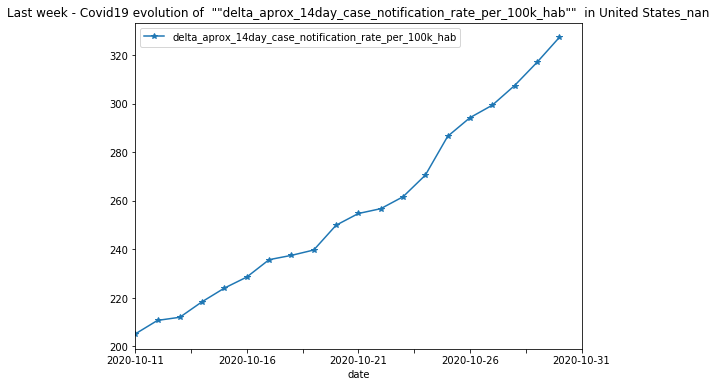

In [20]:
region='United States_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

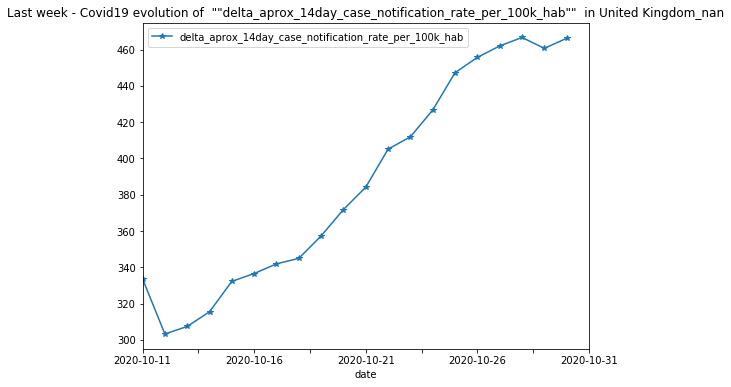

In [21]:
region='United Kingdom_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

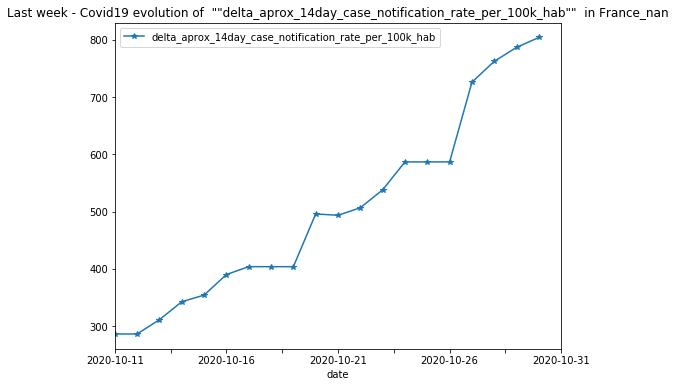

In [22]:
region='France_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

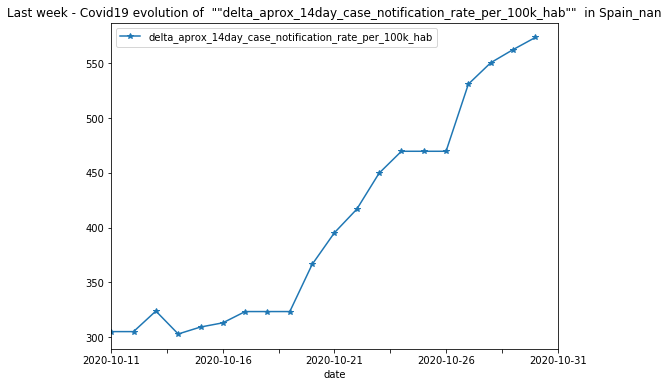

In [23]:
region='Spain_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

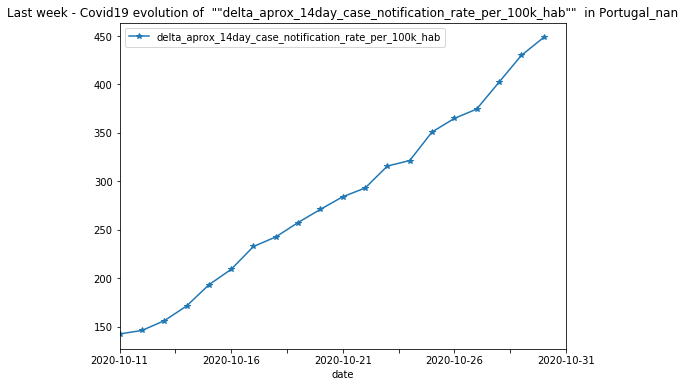

In [24]:
region='Portugal_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

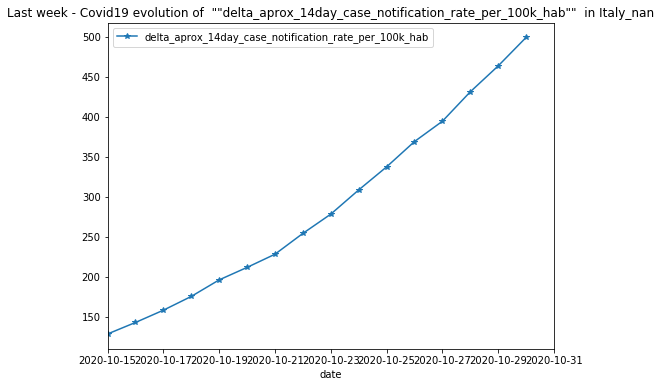

In [25]:
region='Italy_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

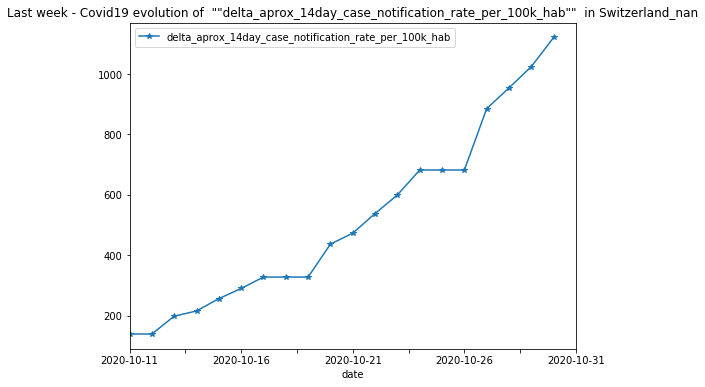

In [26]:
region='Switzerland_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

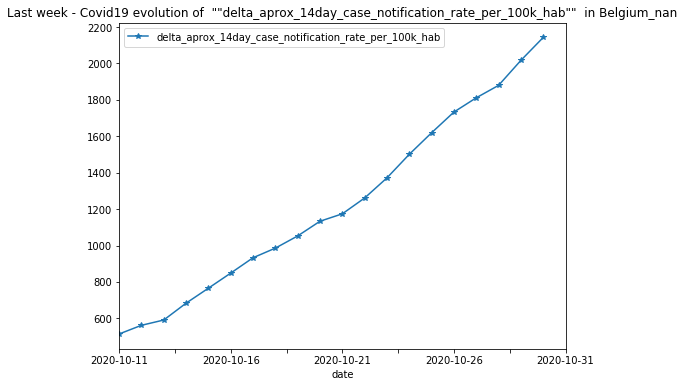

In [27]:
region='Belgium_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

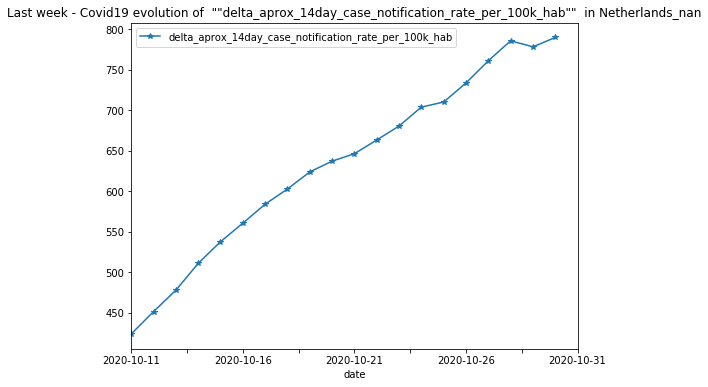

In [28]:
region='Netherlands_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

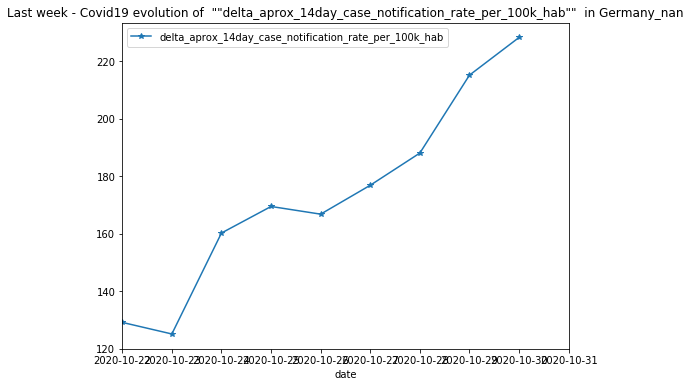

In [29]:
region='Germany_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

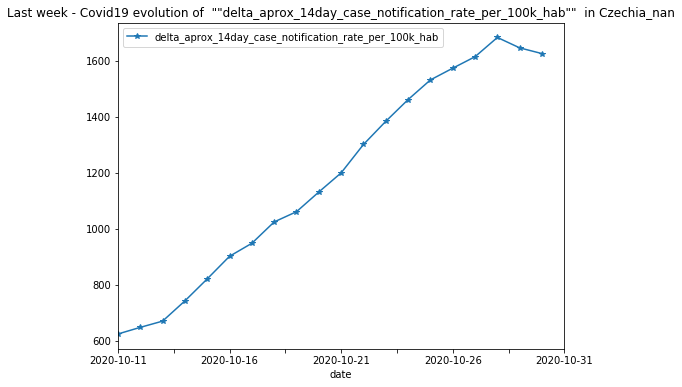

In [30]:
region='Czechia_nan'
eval_var='delta_aprox_14day_case_notification_rate_per_100k_hab'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(8,6),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()

In [37]:
%matplotlib notebook
#%matplotlib inline

<IPython.core.display.Javascript object>


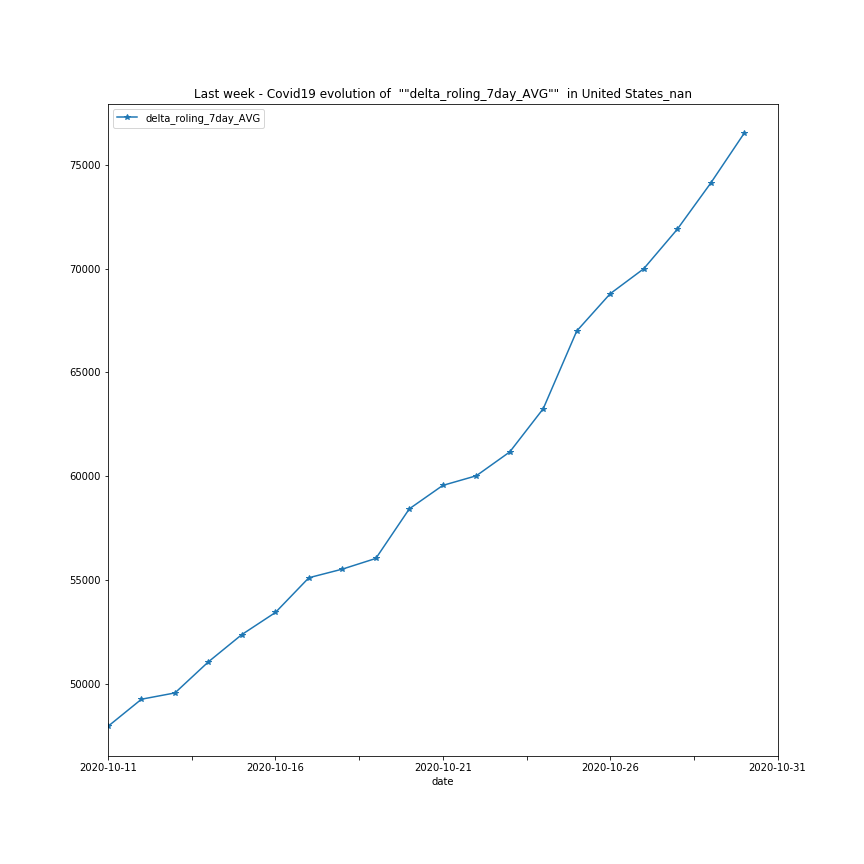

In [38]:
region='United States_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


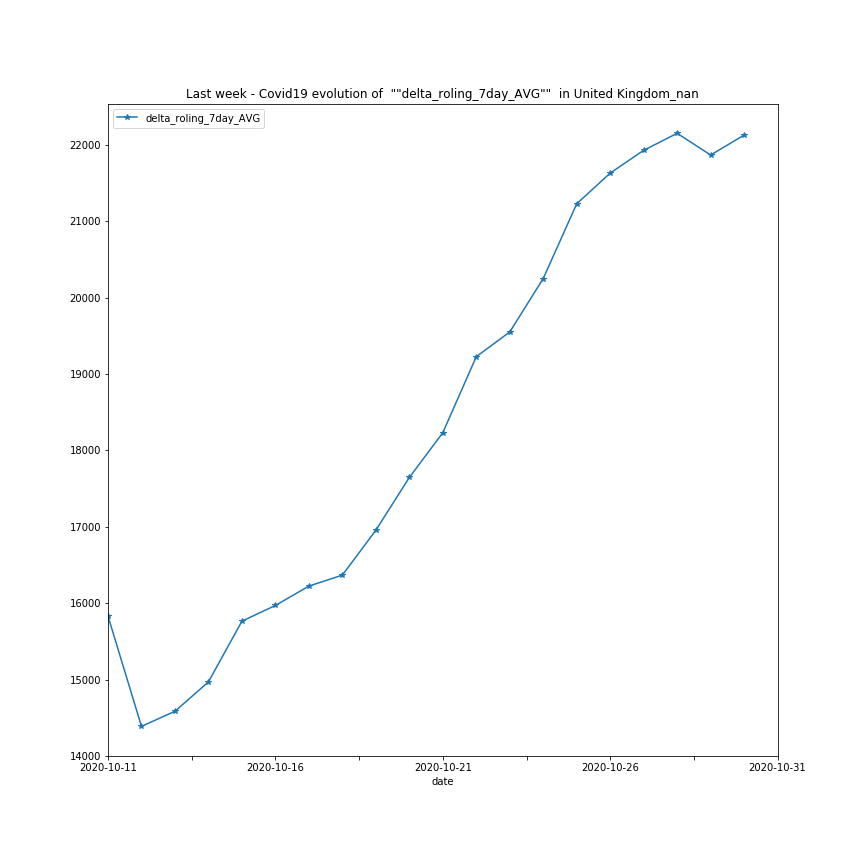

In [39]:
region='United Kingdom_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


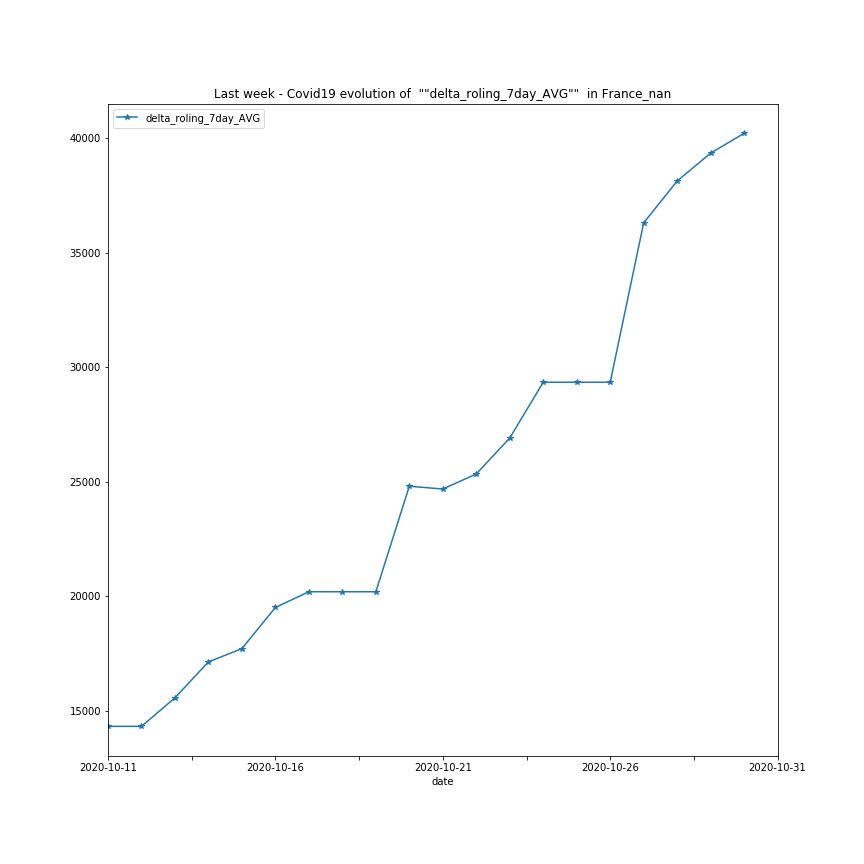

In [40]:
region='France_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


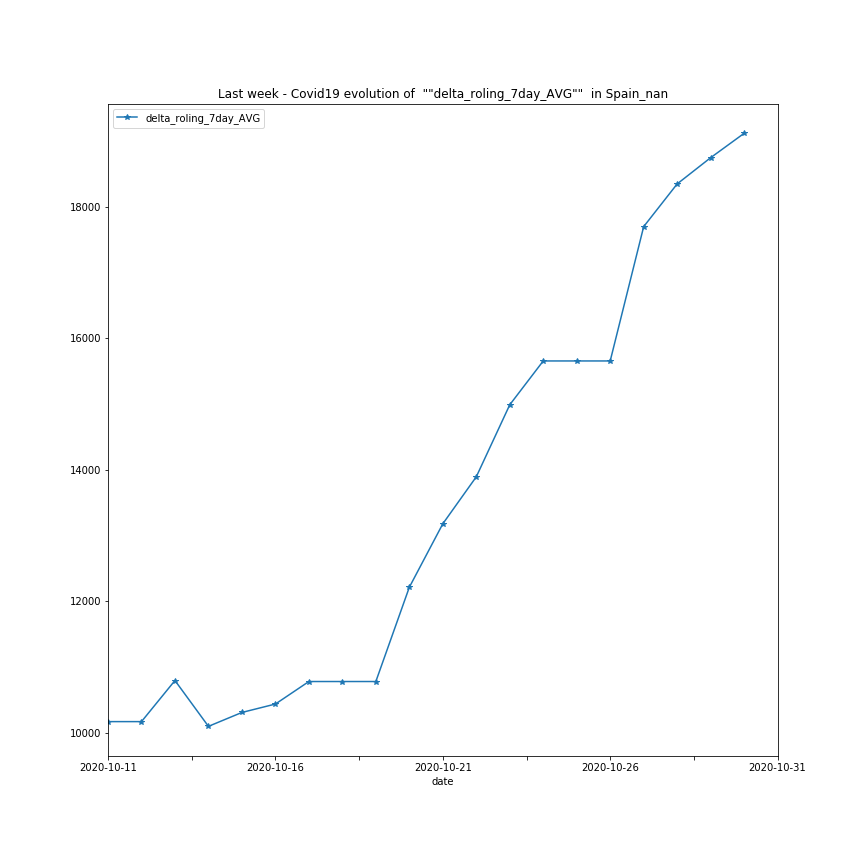

In [41]:
region='Spain_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


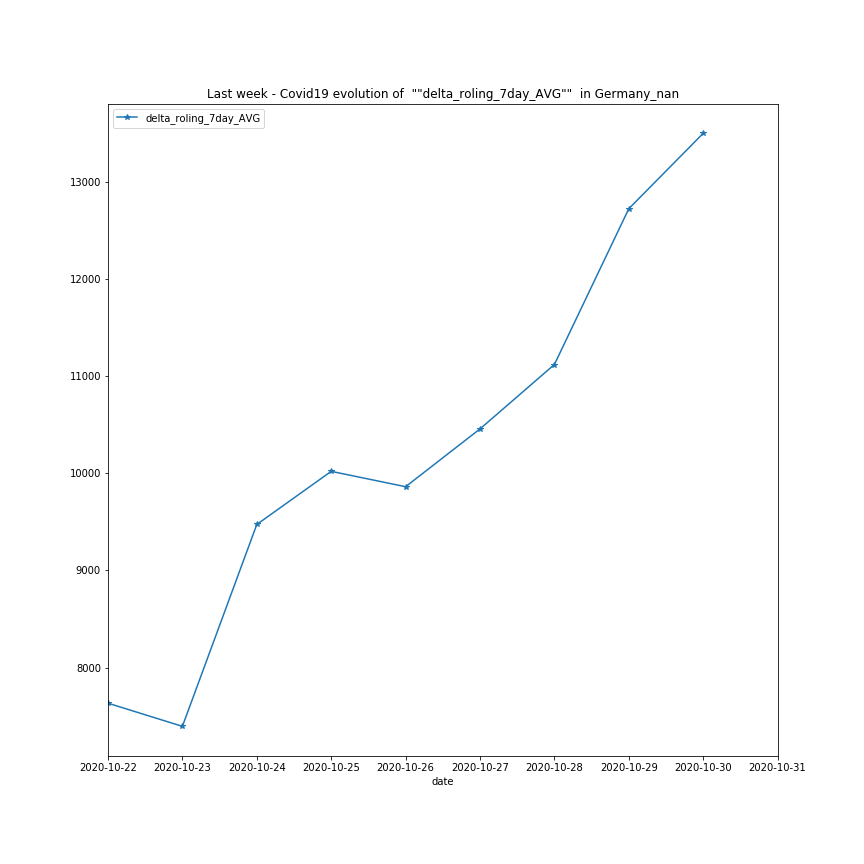

In [42]:
region='Germany_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


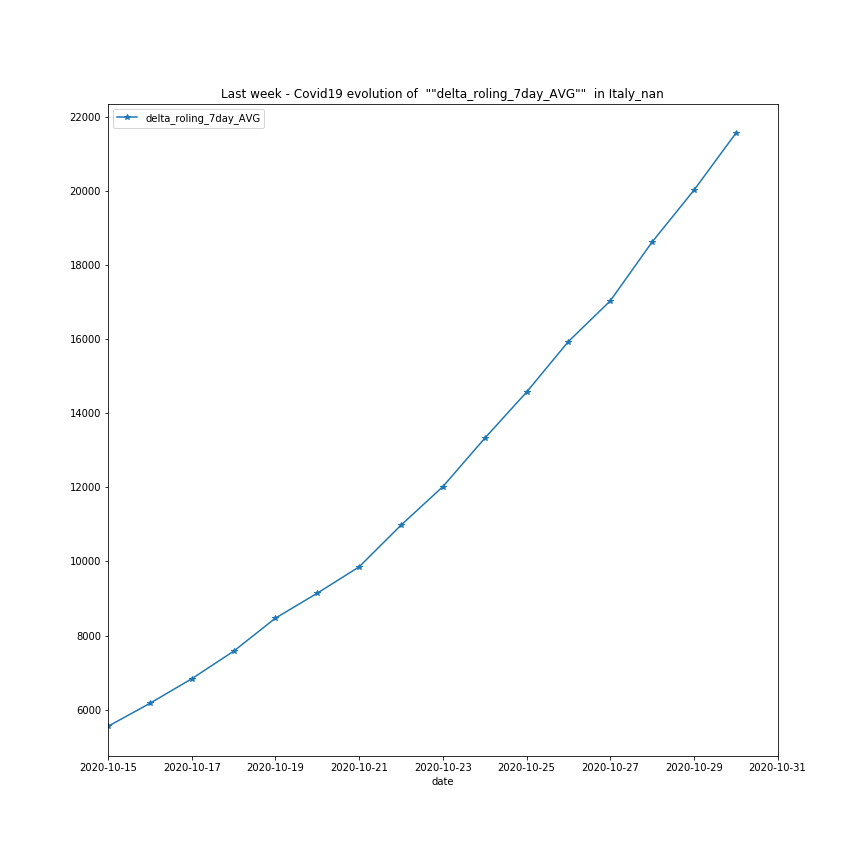

In [43]:
region='Italy_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


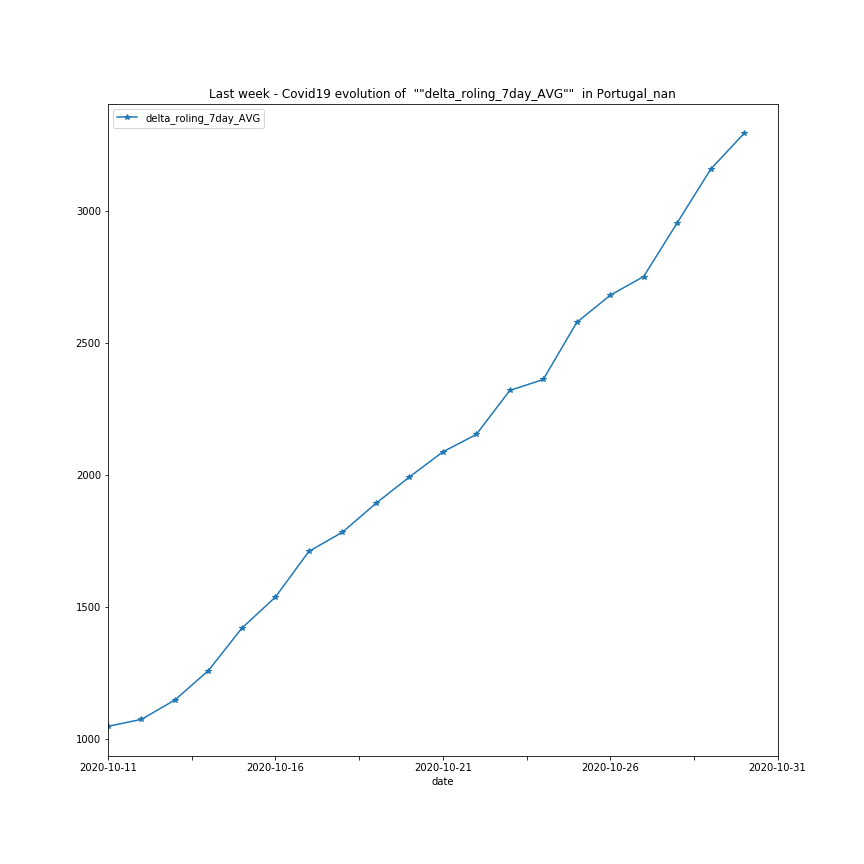

In [44]:
region='Portugal_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


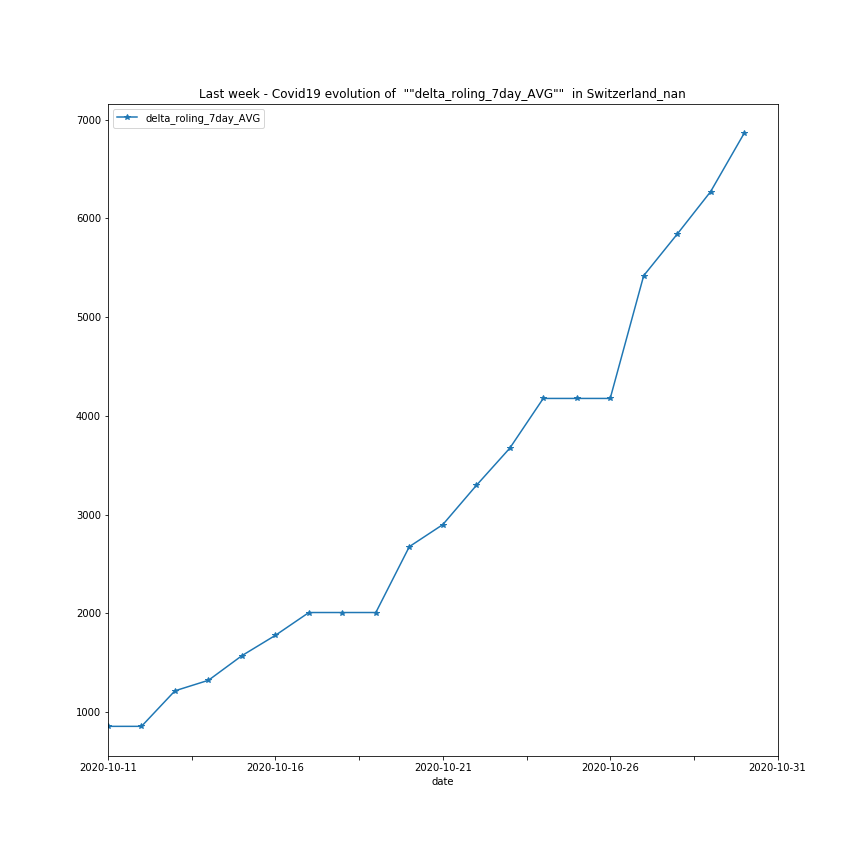

In [45]:
region='Switzerland_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


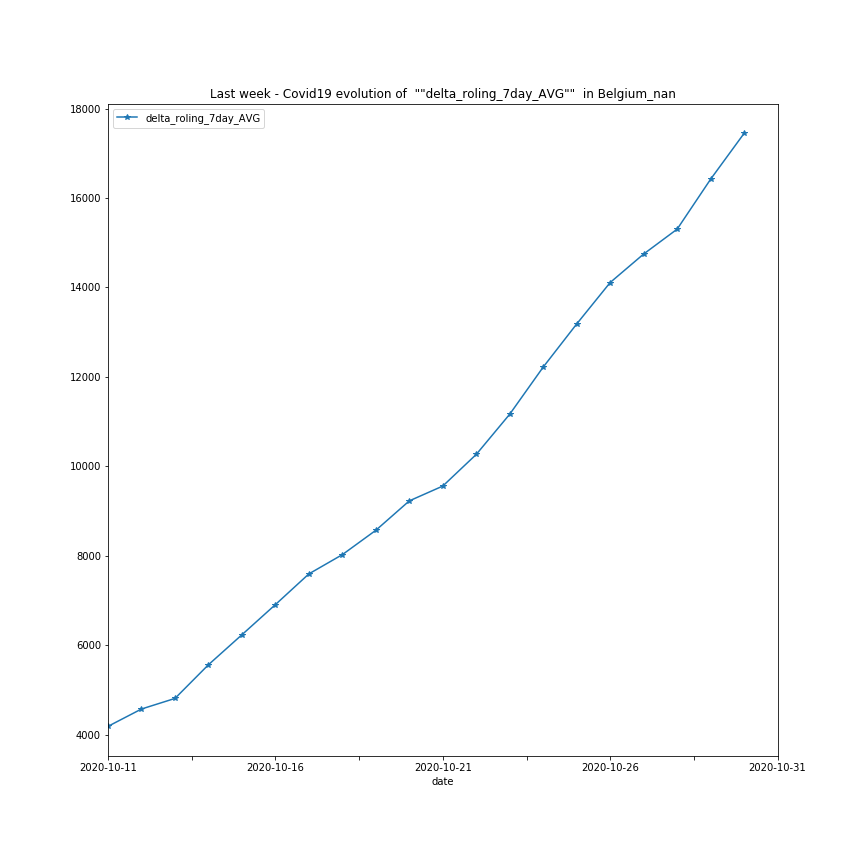

In [46]:
region='Belgium_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


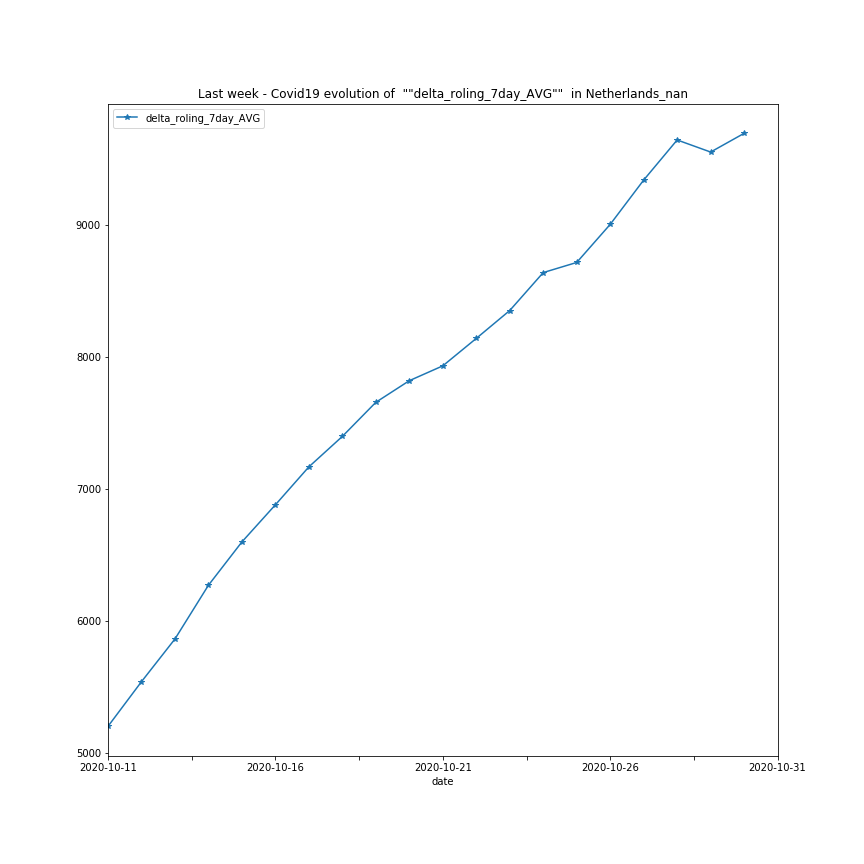

In [47]:
region='Netherlands_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

<IPython.core.display.Javascript object>


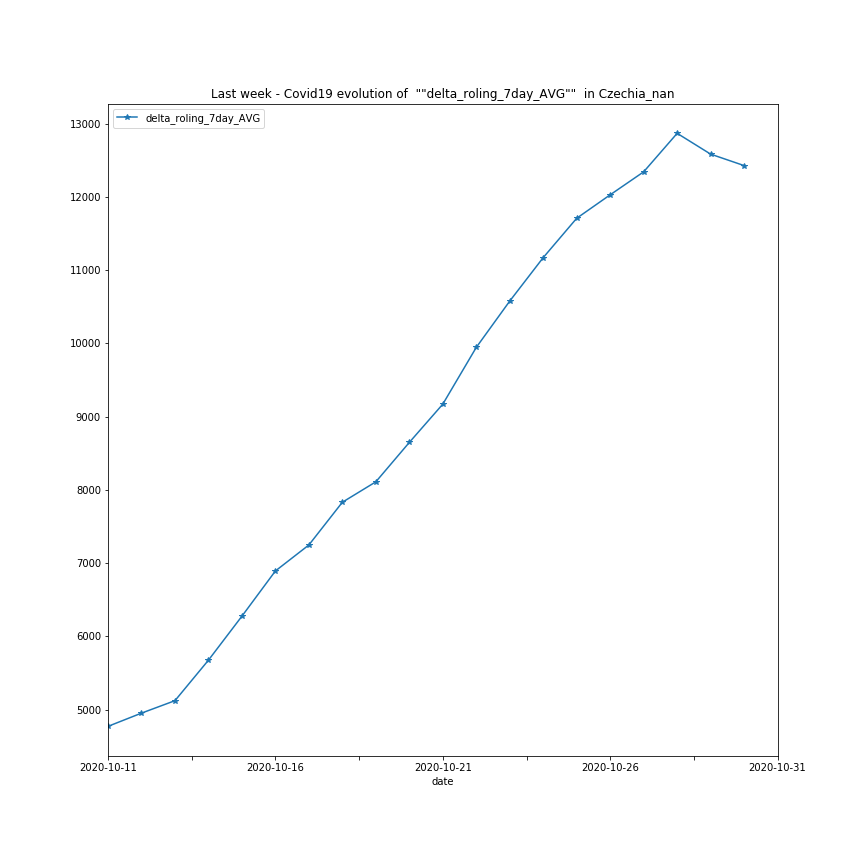

In [48]:
region='Czechia_nan'
eval_var='delta_roling_7day_AVG'
p=t[t['region']==region][['date','region',eval_var]]
#
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p[:].plot(marker='*',figsize=(12,12),title ='Last week - Covid19 evolution of  \""'+eval_var +'\""  in '+region)
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("heatmaps/Daily-Covid19-Analysis-Spark-SQL-Delta.Lake_matplot.pyplot."+region+".png")

In [49]:
print("Validation analysis for 1day-Frecast display purpose at https://FuelBigData.com/blog , done!")

Validation analysis for 1day-Frecast display purpose at https://FuelBigData.com/blog , done!


In [50]:
exit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
